In [57]:
# !pip install catboost
# !pip install pycaret   =====  관리자권한으로실행

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from pycaret.regression import *

import re 

import warnings
warnings.filterwarnings(action='ignore')

#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
sns.set()

#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
from IPython.core.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)


# Load Daata

In [58]:
train = pd.read_csv("../dataset/train.csv", parse_dates=["일자"])
test  = pd.read_csv("../dataset/test.csv", parse_dates=["일자"])
submit = pd.read_csv("../dataset/sample_submission.csv")

In [59]:
print(train.shape)
print(train.info())
train.head(2)      

(1205, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1205 non-null   datetime64[ns]
 1   요일              1205 non-null   object        
 2   본사정원수           1205 non-null   int64         
 3   본사휴가자수          1205 non-null   int64         
 4   본사출장자수          1205 non-null   int64         
 5   본사시간외근무명령서승인건수  1205 non-null   int64         
 6   현본사소속재택근무자수     1205 non-null   float64       
 7   조식메뉴            1205 non-null   object        
 8   중식메뉴            1205 non-null   object        
 9   석식메뉴            1205 non-null   object        
 10  중식계             1205 non-null   float64       
 11  석식계             1205 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(4), object(4)
memory usage: 113.1+ KB
None


,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,"모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐어채무침 포기김치 (배추,고추가루:국내산)","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 청포묵무침 요구르트 포기김치 (배추,고추가루:국내산)","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 포기김치 (김치:국내산)",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,"모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌개 시래기조림 포기김치 (배추,고추가루:국내산)","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무침 요구르트 배추겉절이 (배추,고추가루:국내산)","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무침 바나나 포기김치 (배추,고추가루:국내산)",867.0,560.0


In [60]:
print(test.shape)
print(test.info())
test.head(2)      

(50, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              50 non-null     datetime64[ns]
 1   요일              50 non-null     object        
 2   본사정원수           50 non-null     int64         
 3   본사휴가자수          50 non-null     int64         
 4   본사출장자수          50 non-null     int64         
 5   본사시간외근무명령서승인건수  50 non-null     int64         
 6   현본사소속재택근무자수     50 non-null     float64       
 7   조식메뉴            50 non-null     object        
 8   중식메뉴            50 non-null     object        
 9   석식메뉴            50 non-null     object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 4.0+ KB
None


,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴
0,2021-01-27,수,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자전 양상추샐러드/사과 포기김치,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추샐러드*딸기D,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치
1,2021-01-28,목,2983,104,212,409,348.0,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 양상추샐러드 포기김치,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상추샐러드*오미자D,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지


In [61]:
submit.head(3)

,일자,중식계,석식계
0,2021-01-27,0,0
1,2021-01-28,0,0
2,2021-01-29,0,0


# EDA

In [62]:
plt.rc('font', family='NanumGothic') # For MacOS

## Categorical(Object) 타입 

In [63]:
col_list = train.select_dtypes(include="object").columns
print(col_list)
print(train['요일'].value_counts())

Index(['요일', '조식메뉴', '중식메뉴', '석식메뉴'], dtype='object')
목    244
월    241
금    241
화    240
수    239
Name: 요일, dtype: int64


## Numeric  타입 

In [64]:
col_list = train.select_dtypes(exclude="object").columns
print(col_list)
for col in col_list:
    print(col, train[col].nunique(), train[col].unique()[:10])

Index(['일자', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수',
       '중식계', '석식계'],
      dtype='object')
일자 1205 ['2016-02-01T00:00:00.000000000' '2016-02-02T00:00:00.000000000'
 '2016-02-03T00:00:00.000000000' '2016-02-04T00:00:00.000000000'
 '2016-02-05T00:00:00.000000000' '2016-02-11T00:00:00.000000000'
 '2016-02-12T00:00:00.000000000' '2016-02-15T00:00:00.000000000'
 '2016-02-16T00:00:00.000000000' '2016-02-17T00:00:00.000000000']
본사정원수 53 [2601 2624 2643 2635 2637 2644 2769 2670 2689 2705]
본사휴가자수 347 [ 50  56 104 278 383 389  87  72  78  77]
본사출장자수 194 [150 173 180 220 181 143 156 204 236 250]
본사시간외근무명령서승인건수 507 [238 319 111 355  34 417  93 482 526  23]
현본사소속재택근무자수 165 [ 0.  5.  7.  3.  1. 14. 12. 19. 15. 16.]
중식계 628 [1039.  867. 1017.  978.  925. 1045.  909. 1268. 1014.  916.]
석식계 405 [331. 560. 573. 525. 330. 550. 598. 672. 523. 588.]


In [65]:
# import pandas_profiling as pp
# plt.rc('font', family='NanumGothic') # For MacOS
# report = train.profile_report()
# report.to_file("./EDA.html")

## trian_test 합치기

In [66]:
train_test = pd.concat([train, test], axis=0)

### 파생변수 : 자기개발의날여부 

In [67]:
train_test[train_test['석식메뉴'].str.len()<=20]['석식메뉴'].value_counts()

    *                   19
                         4
    자기계발의날               3
    자기개발의날               3
     *                   2
      *                  2
    *  자기계발의날  *         2
    *  자기개발의날  *         2
      자기계발의날             1
      *자기계발의날*           1
      가정의날               1
   *  자기개발의날  *          1
 ＜자기 계발의 날＞              1
Name: 석식메뉴, dtype: int64

In [68]:
train_test.loc[train_test['석식메뉴'].str.len()<=20, '석식메뉴'] = '자기개발의날'
train_test['자기개발의날여부'] = np.where( train_test['석식메뉴']=='자기개발의날', 1, 0)
print(train_test['자기개발의날여부'].value_counts())

0    1213
1      42
Name: 자기개발의날여부, dtype: int64


### 파생변수 : 일자 관련

In [69]:
train_test['PC_y'] = train_test['일자'].dt.year
train_test['PC_m'] = train_test['일자'].dt.month
train_test['PC_d'] = train_test['일자'].dt.day
train_test['PC_w'] = train_test['일자'].dt.dayofweek  #0:월~6:일
train_test['PC_ws'] = train_test['일자'].dt.weekofyear   #주수
train_test['PC_ym'] =  train_test['일자'].dt.strftime('%Y%m').astype('int')
train_test['PC_md'] =  train_test['일자'].dt.strftime('%m%d').astype('int')

### 메뉴 분리

In [70]:
# train_test_menu = train_test[['일자','중식메뉴','석식메뉴']].copy()
# train_test_menu.head(2)

### 불필요한 컬럼 삭제

In [71]:
train_test = train_test.drop(['요일', '조식메뉴'], axis=1) #,'중식메뉴','석식메뉴'
print(train_test.info())
train_test.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1255 entries, 0 to 49
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1255 non-null   datetime64[ns]
 1   본사정원수           1255 non-null   int64         
 2   본사휴가자수          1255 non-null   int64         
 3   본사출장자수          1255 non-null   int64         
 4   본사시간외근무명령서승인건수  1255 non-null   int64         
 5   현본사소속재택근무자수     1255 non-null   float64       
 6   중식메뉴            1255 non-null   object        
 7   석식메뉴            1255 non-null   object        
 8   중식계             1205 non-null   float64       
 9   석식계             1205 non-null   float64       
 10  자기개발의날여부        1255 non-null   int32         
 11  PC_y            1255 non-null   int64         
 12  PC_m            1255 non-null   int64         
 13  PC_d            1255 non-null   int64         
 14  PC_w            1255 non-null   int64         
 15  PC_ws 

,일자,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,자기개발의날여부,PC_y,PC_m,PC_d,PC_w,PC_ws,PC_ym,PC_md
0,2016-02-01,2601,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 청포묵무침 요구르트 포기김치 (배추,고추가루:국내산)","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 포기김치 (김치:국내산)",1039.0,331.0,0,2016,2,1,0,5,201602,201
1,2016-02-02,2601,50,173,319,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무침 요구르트 배추겉절이 (배추,고추가루:국내산)","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무침 바나나 포기김치 (배추,고추가루:국내산)",867.0,560.0,0,2016,2,2,1,5,201602,202
2,2016-02-03,2601,56,180,111,0.0,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 견과류조림 요구르트 포기김치 (배추,고추가루:국내산)","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기전 (돼지고기:국내산) 새송이버섯볶음 포기김치 (배추,고추가루:국내산)",1017.0,573.0,0,2016,2,3,2,5,201602,203
3,2016-02-04,2601,104,220,355,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 요구르트 포기김치 (배추,고추가루:국내산)","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포기김치 (배추,고추가루:국내산)",978.0,525.0,0,2016,2,4,3,5,201602,204
4,2016-02-05,2601,278,181,34,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채 청경채무침 요구르트 포기김치 (배추,고추가루:국내산)","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:국내산) 감자소세지볶음 콩나물무침 포기김치 (배추,고추가루:국내산)",925.0,330.0,0,2016,2,5,4,5,201602,205


## 분포도

In [72]:
print(train['일자'].min(), train['일자'].max())
print(test['일자'].min(), test['일자'].max())

2016-02-01 00:00:00 2021-01-26 00:00:00
2021-01-27 00:00:00 2021-04-09 00:00:00


* <font color=red> 년도 안겹친다.. 년도 정보를 넣게 되면 예측력이 떨어질 것이다.
  ?? 확인 필요
</font>

## 상관분석
* 상관 계수 : 공분산을 변수의 표준 편차 곱으로 나눈 값

* 학습 전 PC_w 삭제

# 가공

## 출근 관련 파생 변수

In [73]:
train_test['출근']    = train_test['본사정원수']-(train_test['본사휴가자수']+train_test['본사출장자수']+train_test['현본사소속재택근무자수']).astype('int')
# train_test['출근비율'] = train_test['출근']/train_test['본사정원수']
# train_test['휴가비율'] = train_test['본사휴가자수']/train_test['본사정원수']
# train_test['출장비율'] = train_test['본사출장자수']/train_test['본사정원수']
# train_test['야근비율'] = train_test['본사시간외근무명령서승인건수']/train_test['출근']
# train_test['재택비율'] = train_test['현본사소속재택근무자수']/train_test['본사정원수']
train_test.head(2)

,일자,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,자기개발의날여부,PC_y,PC_m,PC_d,PC_w,PC_ws,PC_ym,PC_md,출근
0,2016-02-01,2601,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 청포묵무침 요구르트 포기김치 (배추,고추가루:국내산)","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 포기김치 (김치:국내산)",1039.0,331.0,0,2016,2,1,0,5,201602,201,2401
1,2016-02-02,2601,50,173,319,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무침 요구르트 배추겉절이 (배추,고추가루:국내산)","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무침 바나나 포기김치 (배추,고추가루:국내산)",867.0,560.0,0,2016,2,2,1,5,201602,202,2378


* <font color=red>백분위 비율.. 라운드.. 결과가 좋을까???

## 코로나발생 영향도 분석
<pre> 
신종 코로나바이러스 국내 첫 확진자 발생 : 2020.01.20 13:38
질병관리본부는 1월 19일 중국 우한시에서 입국한 중국 국적의 35세 여성(중국 우한시 거주)에 대해 신종 코로나바이러스 감염증 검사를 시행한 결과, 20일 오전 확진자로 확정됐다고 밝혔다.
출처 : 의협신문(http://www.doctorsnews.co.kr)

In [74]:
# train_test[train_test['일자']>'2020-01-20'].head

886532.0 467006.0
186321.0 89430.0
890.0923694779117 468.8815261044177
891.4880382775119 427.89473684210526


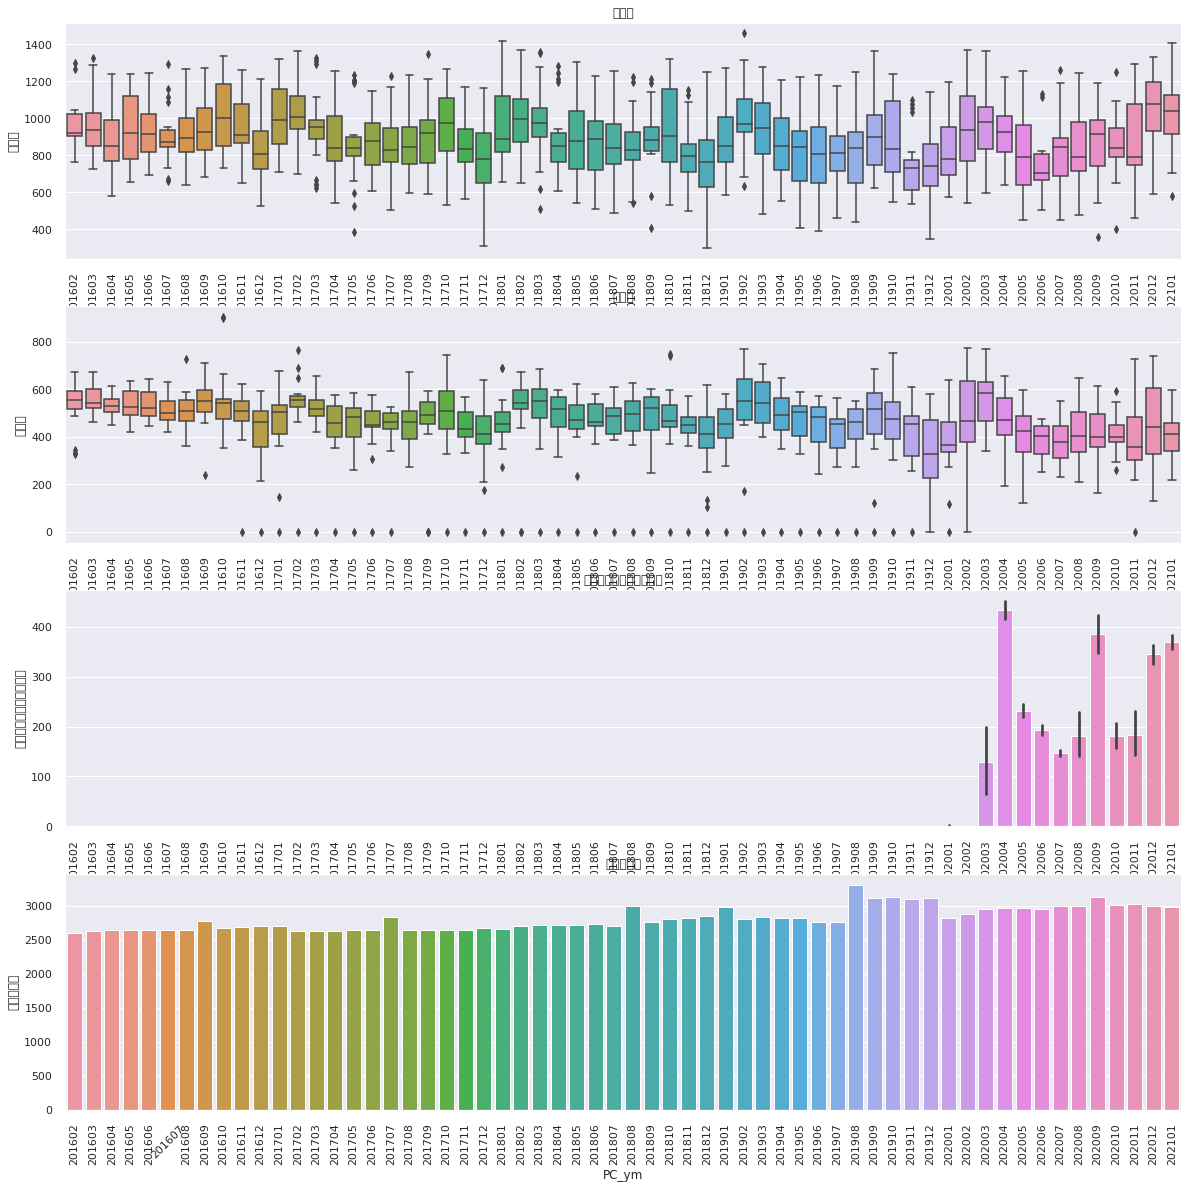

In [81]:
p, axes = plt.subplots(4,1, figsize=(20,20))

box = sns.boxplot(x='PC_ym',y='중식계', data = train_test.iloc[:train.shape[0]], ax=axes[0])
axes[0].set_title('중식계')
for item in box.get_xticklabels():
    item.set_rotation(90)
#----------------------------------------------------
box = sns.boxplot(x='PC_ym',y='석식계', data = train_test.iloc[:train.shape[0]], ax=axes[1])
axes[1].set_title('석식계')
for item in box.get_xticklabels():
    item.set_rotation(90)
#----------------------------------------------------  
# box = sns.boxplot(x='PC_ym',y='현본사소속재택근무자수', data = train_test.iloc[:train.shape[0]], ax=axes[2])
# axes[2].set_title('현본사소속재택근무자수')
# for item in box.get_xticklabels():
#     item.set_rotation(90)
#---------------------------------------------------- 
box = sns.barplot(x='PC_ym',y='현본사소속재택근무자수', data = train_test.iloc[:train.shape[0]], ax=axes[2])
axes[2].set_title('현본사소속재택근무자수')
for item in box.get_xticklabels():
    item.set_rotation(90)
#---------------------------------------------------- 
box = sns.barplot(x='PC_ym',y='본사정원수', data = train_test.iloc[:train.shape[0]], ax=axes[3])
axes[3].set_title('본사정원수')
for item in box.get_xticklabels():
    item.set_rotation(90)

#----------------------------------------------------     
train_test['코로나발생'] = train_test['PC_ym'].apply(lambda x:  1 if x>=202003 else 0)
print( train_test[train_test['코로나발생']==0]['중식계'].sum(), train_test[train_test['코로나발생']==0]['석식계'].sum() )
print( train_test[train_test['코로나발생']==1]['중식계'].sum(), train_test[train_test['코로나발생']==1]['석식계'].sum() )
print( train_test[train_test['코로나발생']==0]['중식계'].mean(), train_test[train_test['코로나발생']==0]['석식계'].mean() )
print( train_test[train_test['코로나발생']==1]['중식계'].mean(), train_test[train_test['코로나발생']==1]['석식계'].mean() )

In [ ]:
temp = train_test.iloc[:train.shape[0]]
temp = temp[temp['PC_ym']>201901]
p, axes = plt.subplots(figsize=(20,6))
box = sns.lineplot(x='PC_ym',y='출근', data = temp)
box = sns.lineplot(x='PC_ym',y='중식계', data = temp)
box = sns.lineplot(x='PC_ym',y='석식계', data = temp)
for item in box.get_xticklabels():
    item.set_rotation(90)

In [ ]:
print(train_test.iloc[:train.shape[0]].groupby(by=['코로나발생'])[['중식계','석식계']].mean())
print("---"*30)
print(train_test.iloc[:train.shape[0]].groupby(by=['코로나발생'])[['중식계','석식계']].count())
print("---"*30)

p, axes = plt.subplots(1,3, figsize=(20,3))
sns.boxplot(x='코로나발생', y='중식계', data=train_test.iloc[:train.shape[0]], hue="코로나발생", ax=axes[0])
sns.boxplot(x='코로나발생', y='석식계', data=train_test.iloc[:train.shape[0]], hue="코로나발생", ax=axes[1])
sns.heatmap(train_test.iloc[:train.shape[0]][['코로나발생','중식계','석식계']].corr(), fmt=".2f", annot=True, cmap="Blues", ax=axes[2])

plt.show()


* 코로나발생 여부는 중식계, 석식계에 영향력이 없다
* 중식계, 석식계의와의 상관도도 높지않다.
* <font color=red>코로나발생 : drop</font>

### 코로나 발생 전/후 요일 별 중식계


In [ ]:
temp = train_test.iloc[:train.shape[0]]

print(temp[temp['코로나발생']==0].groupby('PC_w')['중식계'].count())
print(temp[temp['코로나발생']==1].groupby('PC_w')['중식계'].count())

p, axes = plt.subplots(1,2, figsize=(20,3))
# sns.barplot(x='PC_w', y='중식계', data=temp, hue='코로나발생', ax=axes[0])
temp[temp['코로나발생']==0].groupby('PC_w')['중식계'].count().sort_index().plot(kind='bar', ax=axes[0])
temp[temp['코로나발생']==1].groupby('PC_w')['중식계'].count().sort_index().plot(kind='bar', ax=axes[0])
axes[0].set_title("중식계 요일별")

temp[temp['코로나발생']==0].groupby('PC_w')['석식계'].count().sort_index().plot(kind='bar', ax=axes[1])
temp[temp['코로나발생']==1].groupby('PC_w')['석식계'].count().sort_index().plot(kind='bar', ax=axes[1])
axes[1].set_title("석식계 요일별")
plt.show()

## 공휴일 관련 영향도 분석

### 캘린더 생성

서비스 URL: http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/{서비스오퍼레이션}
<pre>
서비스	종류		오퍼레이션명
-----	------	--------------
국경일 정보조회	getHoliDeInfo	01: 국경일 (ex: 어린이날, 광복절, 개천절)
공휴일 정보조회	getRestDeInfo
기념일 정보조회	getAnniversaryInfo	02: 기념일 (ex: 의병의 날, 정보보호의 날, 4/19 혁명 기념일)
24절기 정보조회	get24DivisionsInfo	03: 24절기 (ex: 청명, 경칩, 하지)
잡절   정보조회	getSundryDayInfo	04: 잡절 (ex: 단오, 한식)
</pre>

In [ ]:
# ! pip install BeautifulSoup4

In [ ]:
import requests
from urllib import parse
import pandas as pd
from bs4 import BeautifulSoup
from datetime import datetime

def get_holiday(syear=2016, eyear=2021 ) :
    api_key_utf8 = "pLlZwGigTf4euiGFUdQ7ktJfpWwXA5CiHJPPtfQgwx45SHhTgIiEjF4k72HaTqHiet8qB%2F0JYw1XYOUH%2FKlRSw%3D%3D"
    api_key_decode = parse.unquote(api_key_utf8)
    operation_name_list =['getRestDeInfo'] #,'getHoliDeInfo getAnniversaryInfo','get24DivisionsInfo','getSundryDayInfo']
    
    item_list = []
    for holiday_type in operation_name_list:
        url = "http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/" + holiday_type
        for year in np.arange(syear, eyear+1) : 
            params = {
                "ServiceKey": api_key_decode,
                "solYear": year,
                "numOfRows": 100
            }

            response = requests.get(url, params=params)
            xml = BeautifulSoup(response.text, "lxml")
            items = xml.find('items')
            item_dict = {}
            for item in items:
                item_dict = {
                    "날짜": datetime.strptime(item.find("locdate").text.strip(), '%Y%m%d'),
                    "휴일여부": item.find("isholiday").text.strip(),
                    "종류" : item.find("datekind").text.strip(),
                    "이름":  item.find("datename").text.strip()
                }
                item_list.append(item_dict)
            res_df = pd.DataFrame(item_list)
            res_df = res_df.fillna('')
            res_df['휴일여부'].replace('Y', 1, inplace=True)
            res_df['휴일여부'].replace('N', 0, inplace=True)
            res_df['휴일여부'].fillna(0)
            res_df['휴일여부'] = res_df['휴일여부'].astype('int')
            # res_df['휴일여부'] = res_df['일자'].apply(lambda x:  1 if x in list else 0)
    return res_df


#### min date ~ max date 날짜 전체 

In [ ]:
start_date = pd.to_datetime(train_test['일자'].min())  #.year
end_date = pd.to_datetime(train_test['일자'].max())   #.year
print(start_date , end_date)
dates = pd.date_range(start_date,end_date,freq='D') 
date_df = pd.DataFrame({'날짜':dates})
print(date_df.shape)
date_df.head()

#### min date ~ max date 날짜 사이의 공휴일

In [ ]:
# ! pip install lxml

In [ ]:
start_year = start_date.year  #df['일자'].min()).year
end_year = end_date.year   #df['일자'].max()).year
holiday_df = get_holiday(start_year,end_year)
print(start_year, end_year, holiday_df.shape)
holiday_df.head()

#### 달력만들기 : 날짜 전체 , 공휴일 

In [ ]:
cal_df = pd.merge(date_df, holiday_df[holiday_df['종류']=='01'][['날짜','휴일여부']] , on='날짜', how='left')
cal_df.fillna(0, inplace=True)
cal_df['휴일여부'] = cal_df['휴일여부'].astype('int')
print(cal_df.shape)
cal_df.head()

In [ ]:
cal_df['전일휴일'] = cal_df['휴일여부'].shift(1)
cal_df['다음날휴일'] = cal_df['휴일여부'].shift(-1)
cal_df = cal_df.fillna(0)
cal_df['전일휴일']   = cal_df['전일휴일'].astype('int')
cal_df['다음날휴일'] = cal_df['다음날휴일'].astype('int')
cal_df.head(10)

In [ ]:
csum_holiday = 0
cal_df["연속휴일수"] = 0
for i in np.arange(cal_df.shape[0]-1, 0, -1):
    if cal_df.iloc[i]['휴일여부']==1:
        csum_holiday +=1
    else :
        if cal_df.iloc[i]['다음날휴일']==1 :
            cal_df.at[i,'연속휴일수'] = csum_holiday
            csum_holiday = 0
cal_df.at[cal_df.shape[0]-1,'연속휴일수'] = 2
cal_df.head(12)

In [ ]:
print(train_test.shape)
train_test = pd.merge(train_test, cal_df , left_on='일자', right_on='날짜', how='left')
print(train_test.shape)
train_test.head(2)

In [ ]:
print(train_test['휴일여부'].value_counts())
print(train_test['전일휴일'].value_counts())
print(train_test['다음날휴일'].value_counts())
print(train_test['코로나발생'].value_counts())

### 연속휴일수 영향도 분석

In [ ]:
train_test['연속휴일수'].value_counts()

In [ ]:
train_test[train_test['연속휴일수']==2]

In [ ]:
print(train_test.iloc[:train.shape[0]].groupby(by=['연속휴일수'])[['중식계','석식계']].mean())
print("---"*30)
print(train_test.iloc[:train.shape[0]].groupby(by=['연속휴일수'])[['중식계','석식계']].count())
print("---"*30)
print(train_test.iloc[:train.shape[0]]['연속휴일수'].value_counts())
print("---"*30)
print(train_test.iloc[train.shape[0]:]['연속휴일수'].value_counts())
print("---"*30)

p, axes = plt.subplots(1,5, figsize=(20,3))
sns.boxplot(x='연속휴일수', y='중식계', data=train_test.iloc[:train.shape[0]], ax=axes[0])
sns.boxplot(x='연속휴일수', y='석식계', data=train_test.iloc[:train.shape[0]], ax=axes[1])
sns.countplot(x='연속휴일수', data=train_test.iloc[:train.shape[0]], ax=axes[2])
sns.countplot(x='연속휴일수', data=train_test.iloc[train.shape[0]:], ax=axes[3])
sns.heatmap(train_test.iloc[:train.shape[0]][['연속휴일수','중식계','석식계']].corr(), fmt=".2f", annot=True, cmap="Blues", ax=axes[4])
plt.show()


*  <font color='red'>연속휴일수는 석식계에 큰 영향을 준다</font>
* 그러나 train에는 [0,1,3,4]  test에는 [0,2,3] : 학습이 안된 값이 나올 수 있다. --> 예측저하
* 중식, 석식과의 상관도는 높지않다.
* <font color=red>연속휴일수 : drop</font>

### 전일휴일 영향도 분석

In [ ]:
print(train_test.iloc[:train.shape[0]].groupby(by=['전일휴일'])[['중식계','석식계']].mean())
print("---"*30)
print(train_test.iloc[:train.shape[0]].groupby(by=['전일휴일'])[['중식계','석식계']].count())
print("---"*30)
print(train_test.iloc[:train.shape[0]]['전일휴일'].value_counts())
print("---"*30)
print(train_test.iloc[train.shape[0]:]['전일휴일'].value_counts())
print("---"*30)

p, axes = plt.subplots(1,5, figsize=(20,3))
sns.boxplot(x='전일휴일', y='중식계', data=train_test.iloc[:train.shape[0]], ax=axes[0])
sns.boxplot(x='전일휴일', y='석식계', data=train_test.iloc[:train.shape[0]], ax=axes[1])
sns.countplot(x='전일휴일', data=train_test.iloc[:train.shape[0]], ax=axes[2])
sns.countplot(x='전일휴일', data=train_test.iloc[train.shape[0]:], ax=axes[3])
sns.heatmap(train_test.iloc[:train.shape[0]][['전일휴일','중식계','석식계']].corr(), fmt=".2f", annot=True, cmap="Blues", ax=axes[4])
plt.show()


*  <font color='red'>전일휴일은 중식계에 영향을 미친다.</font>

### 다음날휴일 영향도 분석

In [ ]:
print(train_test.iloc[:train.shape[0]].groupby(by=['다음날휴일'])[['중식계','석식계']].mean())
print("---"*30)
print(train_test.iloc[:train.shape[0]].groupby(by=['다음날휴일'])[['중식계','석식계']].count())
print("---"*30)
print(train_test.iloc[:train.shape[0]]['다음날휴일'].value_counts())
print("---"*30)
print(train_test.iloc[train.shape[0]:]['다음날휴일'].value_counts())
print("---"*30)

p, axes = plt.subplots(1,5, figsize=(20,3))
sns.boxplot(x='다음날휴일', y='중식계', data=train_test.iloc[:train.shape[0]], ax=axes[0])
sns.boxplot(x='다음날휴일', y='석식계', data=train_test.iloc[:train.shape[0]], ax=axes[1])
sns.countplot(x='다음날휴일', data=train_test.iloc[:train.shape[0]], ax=axes[2])
sns.countplot(x='다음날휴일', data=train_test.iloc[train.shape[0]:], ax=axes[3])
sns.heatmap(train_test.iloc[:train.shape[0]][['다음날휴일','중식계','석식계']].corr(), fmt=".2f", annot=True, cmap="Blues", ax=axes[4])
plt.show()

* <font color='red'>다음날휴일은 중식계에 영향을 미친다</font>
* <font color='red'>다음날휴일은 석식계에 많은 영향을 미친다</font>

## 자기개발의날 영향도 분석

In [ ]:
print(train_test.iloc[:train.shape[0]].groupby(by=['자기개발의날여부'])[['중식계','석식계']].mean())
print("---"*30)
print(train_test.iloc[:train.shape[0]].groupby(by=['자기개발의날여부'])[['중식계','석식계']].count())
print("---"*30)
print(train_test.iloc[:train.shape[0]]['자기개발의날여부'].value_counts())
print("---"*30)
print(train_test.iloc[train.shape[0]:]['자기개발의날여부'].value_counts())
print("---"*30)

p, axes = plt.subplots(1,5, figsize=(20,3))
sns.boxplot(x='자기개발의날여부', y='중식계', data=train_test.iloc[:train.shape[0]], ax=axes[0])
sns.boxplot(x='자기개발의날여부', y='석식계', data=train_test.iloc[:train.shape[0]], ax=axes[1])
sns.countplot(x='자기개발의날여부', data=train_test.iloc[:train.shape[0]], ax=axes[2])
sns.countplot(x='자기개발의날여부', data=train_test.iloc[train.shape[0]:], ax=axes[3])
sns.heatmap(train_test.iloc[:train.shape[0]][['자기개발의날여부','중식계','석식계']].corr(), fmt=".2f", annot=True, cmap="Blues", ax=axes[4])
plt.show()

* <font color='red'>자기개발의날여부는 석식계에 <b>매우 큰</b> 영향을 준다</font>
* 그러나 train에는 [0,1] <font color='red'>test에는 [0] : 학습할 필요가 없다</font>
* 석식과의 상관도는 높다(-0.62)
* <font color=red>자기개발의날 : drop</font>

In [ ]:
train_test.info()

## 중식메뉴/석식메뉴 카테고리화 

### 정규화 처리
<pre>
정규표현식
특정문자 제거            : str.replace(/\-/g,'');
앞의 공백 제거           : str.replace(/^\s+/,'');
뒤의 공백 제거          : str.replace(/\s+$/,'');
앞뒤 공백 제거          : str.replace(/^\s+|\s+$/g,'');
문자열 내의 공백 제거  : str.replace(/\s/g,'');
개행 제거                : str.replace(/\n/g,'');
엔터 제거                : str.replace(/\r/g,'');
0 제거                   : str.replace(/[^(1-9)]/gi,"");

In [ ]:
def reg_exclude_(text):
    text = re.sub(r'/^\s+|\s+$/g', '', text.strip())#앞뒤 공백 제거
    text = text.replace(r' /','/')  #앞뒤 공백 제거
    text = text.replace(r'/ ','/')  #앞뒤 공백 제거

    list = text.split()
    relist = []
    for item in list:
        item = re.sub(r'\([^)]*\)', '', item.strip())               #(s) 제거
        item = re.sub(r'\/.+?$', '', item.strip())                  # /s 제거        
        item = re.sub(r'[^)]*\)', '', item.strip())                #s) 제거
        item = re.sub(r'\([^)]*', '', item.strip())                #(s 제거
        item = re.sub(r'\*[^)]*', '', item.strip())                #*s 제거
        item = re.sub(r'\&[^)]*', '', item.strip())                #&s 제거
        item = re.sub(' +', ' ', item.strip())                     #공백,탭 제거
        if len(item) > 0:
            relist.append(item)
    return ' '.join(relist)
train_test['중식메뉴2'] = train_test['중식메뉴'].apply(lambda x: reg_exclude_(x))
train_test['석식메뉴2'] = train_test['석식메뉴'].apply(lambda x: reg_exclude_(x))

In [ ]:
train_test[['중식메뉴','중식메뉴2']].head(3)

In [ ]:
lens = [len(row) for row in train_test['중식메뉴2'].str.split().tolist()]
print(np.unique(lens))

lens = [len(row) for row in train_test['석식메뉴2'].str.split().tolist()]
print(np.unique(lens))

In [ ]:
menu_lunch  = pd.DataFrame(train_test['중식메뉴2'].str.split().tolist(), columns=["m1","m2","m3","m4","m5","m6","m7","m8"])
menu_dinner = pd.DataFrame(train_test['석식메뉴2'].str.split().tolist(), columns=["m1","m2","m3","m4","m5","m6","m7","m8"])
print(menu_lunch.shape, menu_dinner.shape)
menu_lunch.head()

### 메뉴 대략 통일
* 밥:13 / 국:135 / 메인메뉴:201

In [ ]:
# menu[~menu['m1'].str.contains('밥')]
# df.replace(regex={r'^.라이스$': '카레라이스', ' 덮밥': '덮밥'})

print(menu_lunch['m1'].str[-2:].value_counts().sort_index().shape)
menu_lunch['m1'].str[-2:].value_counts().sort_index()

In [ ]:
print(menu_lunch['m2'].str[-3:].value_counts().sort_index().shape)
menu_lunch['m2'].str[-3:].value_counts().sort_index()

In [ ]:
print(menu_lunch['m3'].str[-3:].value_counts().sort_index().shape)
menu_lunch['m3'].str[-3:].value_counts().sort_index()

In [ ]:
from wordcloud import WordCloud

In [ ]:
# p, axes = plt.subplots(1,3, figsize=(20,6))
text = " ".join(menu_lunch['m1'])
wordcloud = WordCloud(max_font_size=100, font_path='C:\\Windows\\Fonts\\\x7f\x7f\x7f\x7fBOLD.TTF').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

In [ ]:
text = " ".join(menu_lunch['m2'])
wordcloud = WordCloud(max_font_size=100, font_path='C:\\Windows\\Fonts\\\x7f\x7f\x7f\x7fBOLD.TTF').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

In [ ]:
text = " ".join(menu_lunch['m3'])
wordcloud = WordCloud(max_font_size=100, font_path='C:\\Windows\\Fonts\\\x7f\x7f\x7f\x7fBOLD.TTF').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

In [ ]:
menu_lunch_dinner = pd.DataFrame(columns=['ml_1','ml_2','ml_3','md_1','md_2','md_3'])
menu_lunch_dinner['ml_1'] = menu_lunch['m1'].str[-2:].astype('category').cat.codes
menu_lunch_dinner['ml_2'] = menu_lunch['m2'].str[-3:].astype('category').cat.codes
menu_lunch_dinner['ml_3'] = menu_lunch['m3'].str[-3:].astype('category').cat.codes  

menu_lunch_dinner['md_1'] = menu_dinner['m1'].str[-2:].astype('category').cat.codes
menu_lunch_dinner['md_2'] = menu_dinner['m2'].str[-3:].astype('category').cat.codes
menu_lunch_dinner['md_3'] = menu_dinner['m3'].str[-3:].astype('category').cat.codes      

In [ ]:
train_test = pd.concat([train_test, menu_lunch_dinner], axis=1)
print(train_test.shape)
train_test.info()

## 식당 휴업
* 2020년.06.15 ~ 2020.06.30
<pre>
['2018-09-27', '2018-09-28', '2018-10-01', '2018-10-02','2018-10-04', '2018-10-05', 
 '2019-10-01', 
 '2020-06-15','2020-06-16', '2020-06-17', '2020-06-18', '2020-06-19', '2020-06-22', '2020-06-23', '2020-06-24', '2020-06-25',
 '2020-06-26', '2020-06-29','2020-06-30', '2020-09-29','2020-12-28', '2020-12-29','2020-12-30', '2020-12-31']

## 타켓피쳐 로그변환

In [ ]:
train_test.shape

### 중식계/석식계 이상치

In [ ]:
temp = train_test.iloc[:train.shape[0]].copy()
p, axes = plt.subplots(2,4, figsize=(20,10)) 
# 요일 월 년 월년 - 중식계 간 관계
sns.boxplot(temp['PC_w'], temp['중식계'], ax=axes[0][0])
sns.boxplot(temp['PC_m'], temp['중식계'], ax=axes[0][1])
sns.boxplot(temp['PC_y'], temp['중식계'], ax=axes[0][2])
sns.boxplot(temp['PC_ym'], temp['중식계'], ax=axes[0][3])

# 요일 월 년 월년 - 석식계 간 관계
sns.boxplot(temp['PC_w'], temp['석식계'], ax=axes[1][0])
sns.boxplot(temp['PC_m'], temp['석식계'], ax=axes[1][1])
sns.boxplot(temp['PC_y'], temp['석식계'], ax=axes[1][2])
sns.boxplot(temp['PC_ym'], temp['석식계'], ax=axes[1][3])
plt.show()


<pre>
* 석식계가 0인 날이 존재한다.
   매달 - 화, 수, 금 요일 중 석식이 0이다
   2020년 코로나 발병 이후 석식계가 0인날은 없다  
* 코로나 발병(2020-02) 기준으로 변화
   중식계가 늘었다
   석식계가 줄었다
* 이상치가 존재한다
  중식계 > 1400   , 석식계=0 ,  석식계>800

In [ ]:
p, axes = plt.subplots(1,2, figsize=(10,3))
sns.distplot(train_test['중식계'], label="중식계", ax=axes[0])
sns.distplot(train_test['석식계'], label="석식계", ax=axes[1])
plt.show()

In [ ]:
train_test[['중식계','석식계']].describe()

In [ ]:
drop_row_idx = temp[(train_test['중식계']>=1400) | (train_test['석식계']>=800)].index
print(drop_row_idx)
temp[(train_test['중식계']>=1400) | (train_test['석식계']>=800)].shape[0]

In [ ]:
print(train_test.shape)
train_test = train_test.drop(drop_row_idx, axis=0)
train_test.shape

#### 이상치 제거 후 

In [ ]:
p, axes = plt.subplots(1,2, figsize=(10,3))
sns.distplot(train_test['중식계'], label="중식계", ax=axes[0])
sns.distplot(train_test['석식계'], label="석식계", ax=axes[1])
plt.show()

* 조금 더 정규화됨
<pre>
제거 전 : 중식계		석식계
  mean	890.334440	461.772614
   std	209.505057	139.179202
제거 후 : 중식계		석식계
  mean	888.311667	460.475000
   std	207.529476	137.788446
   
<font color=red>자기개발의 날은 test에는 없다
즉, 석식계 0인날도 drop??????

In [ ]:
train_test[['중식계','석식계']].describe()

### 중식계/석식계 로그변환

In [ ]:
train_test['중식계2'] = np.log1p(train_test["중식계"])
train_test['석식계2'] = np.log1p(train_test["석식계"])

In [ ]:
p, axes = plt.subplots(1,2, figsize=(10,3))
sns.distplot(train_test['중식계2'], label="중식계2", ax=axes[0])
sns.distplot(train_test['석식계2'], label="석식계2", ax=axes[1])
plt.show()

* 로그 변환 후 정규화 안좋아짐, 왜도가 보임 --> 로그변환 drop

In [ ]:
train_test = train_test.drop(['중식계2','석식계2'], axis=1)

In [ ]:
train_test.shape

## 불필요한 컬럼 삭제
<pre>
  인덱스 : '일자', 
  삭제   : '본사정원수', '연속휴일수',  'PC_ym', 'PC_md',  'PC_ws','날짜', '휴일여부', '중식메뉴', '석식메뉴'
           '중식메뉴2', '석식메뉴2'	
  공통   : '출근', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수',
           'PC_y', 'PC_m', 'PC_w',    ('PC_d', --by 허강호)
           
          '코로나발생' ????
  중식계 : '전일휴일',       ('다음날휴일', )??
  석식계 : '자기개발의날여부', '다음날휴일', 
 
  타겟   : '중식계', '석식계',

In [ ]:
# print(train_test.columns)
#train_test = train_test.drop(['PC_ym','PC_md'], axis=1)

In [ ]:
train_test = train_test.set_index('일자')
train_test = train_test.drop(['본사정원수', '중식메뉴', '석식메뉴', '중식메뉴2', '석식메뉴2', '연속휴일수', 'PC_ym', 'PC_md', 'PC_ws', '날짜', '휴일여부'], axis=1)
train_test.head()

In [ ]:
train_test.info()

## 백업용 저장

In [ ]:
train_test.to_csv("가공완료_ver03.csv", index=False)

In [ ]:
train_test.info()

In [ ]:
train_test.isna().sum()

# 학습 & 평가 (1차)

## train_test 분리
<pre>
* 중식계 데이터
   train_lunch.shape,  test_lunch.shape, y_lunch.shape   : (1200, 14) (55, 14) (1200,)
* 석식계 데이터
   train_dinner.shape, test_dinner.shape, y_dinner.shape : (1200, 15) (55, 15) (1200,)

In [ ]:
train_test.shape[0], train_test['중식계'].notna().sum(), train_test['중식계'].isna().sum()

In [ ]:
train_size = train_test['중식계'].notna().sum()
col_lunch = ['PC_y', 'PC_m', 'PC_d', 'PC_w', 
          '출근', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수',
          '코로나발생', '전일휴일', 'ml_1', 'ml_2', 'ml_3']                  #---- 중식계 주요 피쳐


col_dinner = ['PC_y', 'PC_m', 'PC_d', 'PC_w', 
       '출근', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수',
        '코로나발생', '다음날휴일','자기개발의날여부','md_1', 'md_2', 'md_3']  #---- 석식계 주요 피쳐

train_lunch = train_test[col_lunch].iloc[:train_size]
test_lunch  = train_test[col_lunch].iloc[train_size:]
y_lunch     = train_test.iloc[:train_size]['중식계']

train_dinner = train_test[col_dinner].iloc[:train_size]
test_dinner  = train_test[col_dinner].iloc[train_size:]
y_dinner     = train_test.iloc[:train_size]['석식계']
print(train_lunch.shape, test_lunch.shape, y_lunch.shape)
print(train_dinner.shape, test_dinner.shape, y_dinner.shape)

In [ ]:
train_lunch.head(2)

In [ ]:
y_lunch[:2]

In [ ]:
train_dinner.head(2)

In [ ]:
y_dinner.head()